---
Cloning repo into colab runtime and changing directory to Fall-23-APML-Public/Assignements/HW2

**Do not run this section if notebook is on local machine or if already in the above directory.**

In [ ]:
!git clone https://github.com/elswit/Fall-23-APML-Public.git

Cloning into 'Fall-23-APML-Public'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 42 (delta 8), reused 35 (delta 5), pack-reused 0
Receiving objects: 100% (42/42), 361.97 KiB | 12.48 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
cd /content/Fall-23-APML-Public/Assignements/HW2

/content/Fall-23-APML-Public/Assignements/HW2


---

##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
orig_df = pd.read_csv('../../Datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [ ]:
df = pd.read_csv('../../Datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [ ]:
df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [ ]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [ ]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [ ]:
df.head(3)

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1


**Meaning of each column**:-

> X - X coordinate of the crime location

> Y - Y coordinate of the crime location

> Area_Command -

> NIBRSOffenseCode -

> DayOfWeek - Day of the week on which the crime occured

> Time - Time at which the crime occured

> VictimCount - Number of victims if that crime


**Input variables** - X, Y,	Area_Command,	NIBRSOffenseCode,	DayOfWeek,	Time

**Target variables** - VictimCount

In [ ]:
print('Range of values in each column:')
pd.DataFrame({'Min': df.min(), 'Max': df.max()})

Range of values in each column:


,Min,Max
X,-116.000000,-114.62557
Y,35.068419,37.00000
Area_Command,0.000000,11.00000
NIBRSOffenseCode,0.000000,2.00000
DayOfWeek,0.000000,6.00000
Time,0.000000,23.00000
VictimCount,0.000000,6.00000


In [ ]:
df.describe()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625570,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000


`X and Y can be shifted` to have a mean of 0, since the difference of their min and max values isn't much.

`DayOfWeek and Time` can be scaled.

`VictimCount can be normalized` since it is severly skewed.

## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

X = df.iloc[:, :-1].values  # All columns except the last one
y = df.iloc[:, -1].values  # The last column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=19)

batch_size = 206

# DataLoader for train data
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# DataLoader for test data
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Printing shapes
for batch_num, (batch_X, batch_y) in enumerate(train_dataloader, 1):
    print(f"Train Batch {batch_num} X shape: {batch_X.shape}")
    print(f"Train Batch {batch_num} Y shape: {batch_y.shape}")

for batch_num, (batch_X, batch_y) in enumerate(test_dataloader, 1):
    print(f"Test Batch {batch_num} X shape:: {batch_X.shape}")
    print(f"Test Batch {batch_num} Y shape: {batch_y.shape}")

Train Batch 1 X shape: torch.Size([206, 6])
Train Batch 1 Y shape: torch.Size([206])
Test Batch 1 X shape:: torch.Size([69, 6])
Test Batch 1 Y shape: torch.Size([69])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
> Since it's a regression problem we can use, Mean sqaured error as a loss function.
* what should the size of the predicted output be?
> The output size will be 1, just a real number.
* explain your choice of architecture, including how many layers you will be using
> A total of 5 layers including the input and the output layer.
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define the neural network architecture with 1 output unit
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(6, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)

    def forward(self, x):
        x = nn.functional.sigmoid(self.fc1(x))
        x = nn.functional.tanh(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.relu(self.fc4(x))
        x = self.fc5(x)
        return x


rmodel = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(rmodel.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.4)

best_test_loss = float('inf')
epochs = 100

for epoch in range(epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = rmodel(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    scheduler.step()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = rmodel(inputs)
            test_loss += criterion(outputs, targets).item()
    test_loss /= len(test_dataloader)
    best_test_loss = min(best_test_loss, test_loss)
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss/MSE: {loss.item()}, Test Loss/MSE: {test_loss}')

print('Best accuracy(MSE) on test dataset:', best_test_loss)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([206])) that is different to the input size (torch.Size([206, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([69])) that is different to the input size (torch.Size([69, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Train Loss/MSE: 1.257391333580017, Test Loss/MSE: 1.0028080940246582
Epoch [2/100], Train Loss/MSE: 1.2206637859344482, Test Loss/MSE: 0.9722529649734497
Epoch [3/100], Train Loss/MSE: 1.1854028701782227, Test Loss/MSE: 0.9487870931625366
Epoch [4/100], Train Loss/MSE: 1.1577532291412354, Test Loss/MSE: 0.9285616278648376
Epoch [5/100], Train Loss/MSE: 1.1343296766281128, Test Loss/MSE: 0.9136436581611633
Epoch [6/100], Train Loss/MSE: 1.116105318069458, Test Loss/MSE: 0.899925708770752
Epoch [7/100], Train Loss/MSE: 1.099538803100586, Test Loss/MSE: 0.8861275911331177
Epoch [8/100], Train Loss/MSE: 1.0824848413467407, Test Loss/MSE: 0.8727756142616272
Epoch [9/100], Train Loss/MSE: 1.065348744392395, Test Loss/MSE: 0.8607704043388367
Epoch [10/100], Train Loss/MSE: 1.0493791103363037, Test Loss/MSE: 0.8504946827888489
Epoch [11/100], Train Loss/MSE: 1.0350054502487183, Test Loss/MSE: 0.8469157218933105
Epoch [12/100], Train Loss/MSE: 1.0297470092773438, Test Loss/MSE: 0

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
> By checking for the number of unique values in the target column (VictimCount).
* How is the architecture different?
> The output layer would have as many units as the number of classes instead of just 1.
* How is the loss function different?
> We will use cross-entropy intead of MSE. As it measures the performance of a model whose output is a probability value between 0 and 1
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

In [ ]:
# Define the neural network architecture for classification

class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(6, 128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cmodel = ClassificationModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cmodel.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.4)

best_test_loss = float('inf')
best_test_acc = 0
epochs = 100

for epoch in range(epochs):
    total_correct = 0
    total_samples = 0

    for i, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = cmodel(inputs)
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()

    scheduler.step()
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = cmodel(inputs)
            loss = criterion(outputs, targets.long())
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
            total_samples += targets.size(0)
            total_correct += (predicted == targets).sum().item()

    test_loss /= len(test_dataloader)
    accuracy = 100 * total_correct / total_samples  # Calculate accuracy as a percentage

    best_test_loss = min(best_test_loss, test_loss)
    best_test_acc = max(best_test_acc, accuracy)
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {loss.item()}, Test Loss: {test_loss}, Test Accuracy: {accuracy:.2f}%')

print('Best loss on test dataset:', best_test_loss, ", best accuracy:", best_test_acc)

Epoch [1/100], Train Loss: 31.34397315979004, Test Loss: 31.34397315979004, Test Accuracy: 53.62%
Epoch [2/100], Train Loss: 144.21055603027344, Test Loss: 144.21055603027344, Test Accuracy: 34.78%
Epoch [3/100], Train Loss: 11.1630220413208, Test Loss: 11.1630220413208, Test Accuracy: 34.78%
Epoch [4/100], Train Loss: 10.151171684265137, Test Loss: 10.151171684265137, Test Accuracy: 53.62%
Epoch [5/100], Train Loss: 1.9305957555770874, Test Loss: 1.9305957555770874, Test Accuracy: 1.45%
Epoch [6/100], Train Loss: 1.8950278759002686, Test Loss: 1.8950278759002686, Test Accuracy: 24.64%
Epoch [7/100], Train Loss: 1.8565603494644165, Test Loss: 1.8565603494644165, Test Accuracy: 37.68%
Epoch [8/100], Train Loss: 1.6028099060058594, Test Loss: 1.6028099060058594, Test Accuracy: 34.78%
Epoch [9/100], Train Loss: 1.1759294271469116, Test Loss: 1.1759294271469116, Test Accuracy: 57.97%
Epoch [10/100], Train Loss: 1.2878944873809814, Test Loss: 1.2878944873809814, Test Accuracy: 53.62%
Epoch 

## Task 5

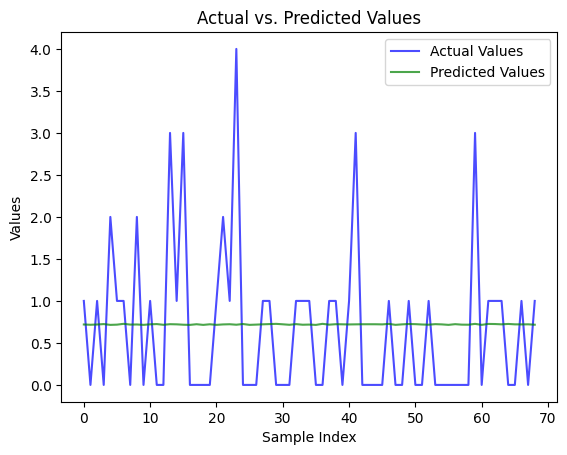

In [ ]:
rmodel.eval()

actual_values, predicted_values = [], []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = rmodel(inputs)
        for i in range(len(targets)):
            actual_value = targets[i].item()
            predicted_value = outputs[i].item()
            actual_values.append(actual_value)
            predicted_values.append(predicted_value)

plt.plot(actual_values, label='Actual Values', color='blue', alpha=0.7)
plt.plot(predicted_values, label='Predicted Values', color='green', alpha=0.7)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np

true_labels = []
predicted_labels = []
cmodel.eval()

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = cmodel(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[37  0  0  0  0]
 [24  0  0  0  0]
 [ 3  0  0  0  0]
 [ 4  0  0  0  0]
 [ 1  0  0  0  0]]


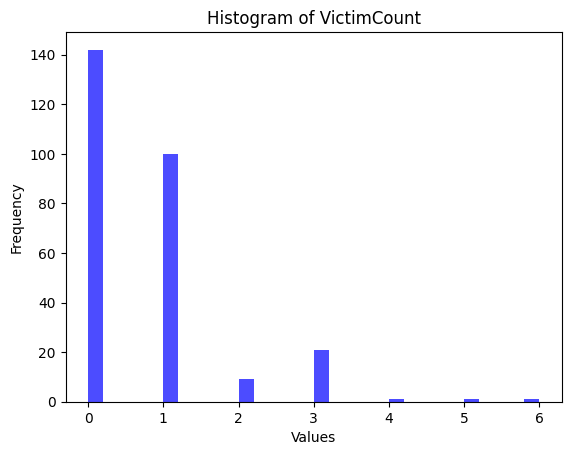

In [ ]:
plt.hist(df['VictimCount'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of VictimCount')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
> Task 3 and 4 involved implementing a regression model and a classification model for predicting the target column. We can check the actual vs predicted values for both the models and then figure out which one worked better.
> Both the models don't work well. In case of the regression model, it always predicts values around 0.62 **(Visualized two cells above)**, and the classifier always predicts 0 **(Confusion Matrix - 1 cell above)**.
> The reason for this is that the target variable has an uneven distribution of samples  **(Visualized in the graph above)**. Most of the crimes have 0 or 1 victim. This imbalance in classes, makes it harder for the networks to actually learn anything.


* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

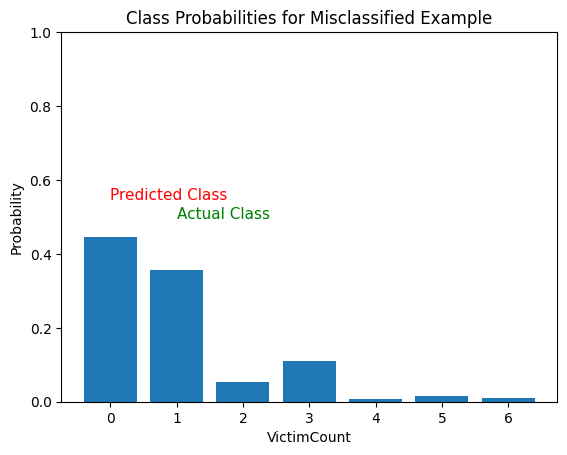

In [ ]:
cmodel.eval()

misclassified_example = None

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = cmodel(inputs)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            if predicted[i] != targets[i]:
                misclassified_example = (inputs[i], targets[i], predicted[i], outputs[i])
                break

input_data, true_class, predicted_class, class_probabilities = misclassified_example
probabilities = torch.softmax(class_probabilities, dim=0).numpy()
class_labels = range(0,7)

plt.bar(class_labels, probabilities)
plt.title('Class Probabilities for Misclassified Example')
plt.xlabel('VictimCount')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.text(predicted_class.item(), max(probabilities) + 0.1, 'Predicted Class', color='red', fontsize=11)
plt.text(true_class.item(), max(probabilities) + 0.05, 'Actual Class', color='green', fontsize=11)
plt.show()

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
> Not much of a pattern. Looks evenly distributed throughout the week.

* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
> Most incidets have none or just 1 victim. There are only a couple of outliers, where the victim count goes up.

* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?
> Day 4 and 3 are the most frequent.


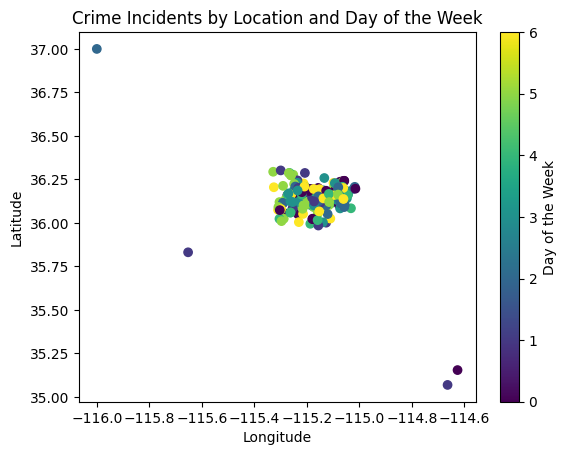

In [ ]:
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'].values)
plt.title('Crime Incidents by Location and Day of the Week')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Day of the Week')
plt.show()

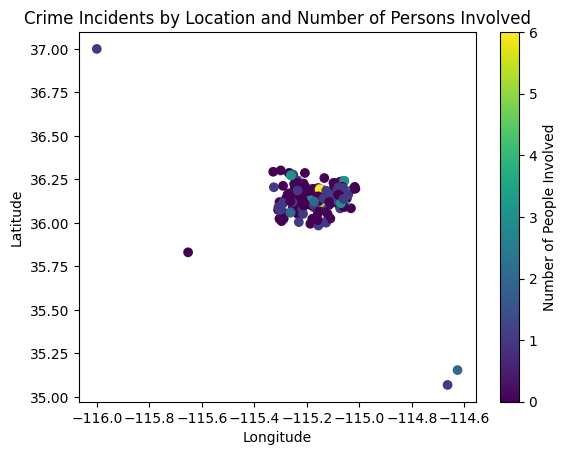

In [ ]:
plt.scatter(df['X'], df['Y'], c=df['VictimCount'].values)
plt.title('Crime Incidents by Location and Number of Persons Involved')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Number of People Involved')
plt.show()

In [ ]:
dow = df['DayOfWeek'].value_counts().reset_index()
dow.columns = ['Day of the week', 'Count']
dow = dow.sort_values(by='Count', ascending=False)
dow.reset_index(drop=True, inplace=True)
print(dow.to_string(index=False))

 Day of the week  Count
               4     51
               3     44
               5     43
               0     40
               1     37
               2     32
               6     28
